In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import time
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 设定参数与CIFAR-10数据集加载

In [2]:
BATCH_SIZE = 200 
EPOCH = 75
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_set = datasets.CIFAR10("datasets",train = True,download = True,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                            ]))

Files already downloaded and verified


In [4]:
test_set = datasets.CIFAR10("datasets",train = False,download = True,
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size = BATCH_SIZE,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = BATCH_SIZE,shuffle = True)

In [6]:
len(train_set),len(test_set),len(train_loader),len(test_loader)

(50000, 10000, 250, 50)

## 训练与测试函数

In [7]:
def train(net,device,train_loader,optimizer,epoch,LOSS):
    n_iter = 0
    net.train()
    for i,(data,target) in enumerate(train_loader):
        Loss = []
        n_iter += 1
        #这个循环走 250 次，一次有200个数据被训练
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target).to(device)
        loss.backward()
        Loss.append(loss.item())
        LOSS.append(loss.item())
        optimizer.step()
        #每 50 次输出一次结果
        if n_iter % 125 == 0: 
            print("Trian Epoch",epoch,(i+1)*len(data),"/",len(train_loader.dataset),end = " ")
            print("LOSS:{:.4f}".format(sum(Loss)/len(Loss)))
        

In [8]:
def test(net,device,test_loader,ACC):#输入中的ACC用于记录每次测试的测试精度
    net.eval()
    n_iter = 0
    correct = 0
    with torch.no_grad():
        for data,target in test_loader:
            n_iter += 1
            data,target = data.to(device),target.to(device)
            output = net(data)
            _,predicted = torch.max(output.data,1)
            correct +=(predicted == target).sum().item()
    ACC.append(100.0*correct/len(test_loader.dataset))
    print("Accuracy on test iamges:{:.3f}%".format(100.0*correct/len(test_loader.dataset)))    

## 网络结构。本次实验采用类AlexNet的网络结构，网络基本单元为[卷积-Relu-池化]，采用全连接层输出
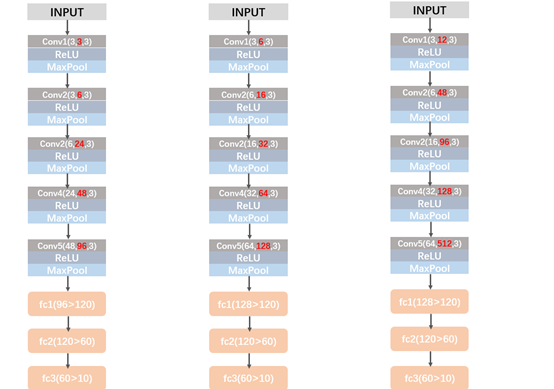

1. 窄：AletNet_widths

In [9]:
class AlexNet_widthS(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,3,3,padding = 1),#（32-3+2）/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入3*32*32，,输出3*16*16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(3,6,3,padding = 1),#(16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入3*16*16，输出6*8*8
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(6,24,3,padding = 1),#(8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入6*8*8，输出24*4*4
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(24,48,3,padding = 1),#4-3+2/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入24*4*4，输出48*2*2
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(48,96,3,padding = 1), #2-3+2+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入48*2*2，输出96*1*1
        )
        self.fc1 = nn.Linear(96,90)
        self.fc2 = nn.Linear(90,60)
        self.fc3 = nn.Linear(60,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        #out = out.view(in_size,-1)
        out = out.view(-1,96)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

2. 中：AlexNet_widthM

In [10]:
class AlexNet_widthM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,6,3,padding = 1),#（32-3+2）/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入3*32*32，,输出6*16*16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,3,padding = 1),#(16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入6*16*16，输出16*8*8
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,32,3,padding = 1),#(8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入16*8*8，输出32*4*4
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32,64,3,padding = 1),#4-3+2/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入32*4*4，输出64*2*2
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64,128,3,padding = 1), #2-3+2+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入64*2*2，输出128*1*1
        )
        self.fc1 = nn.Linear(128,120)
        self.fc2 = nn.Linear(120,60)
        self.fc3 = nn.Linear(60,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        #out = out.view(in_size,-1)
        out = out.view(-1,128)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

3. 宽：AlexNet_widthd

In [11]:
class AlexNet_widthD(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,12,3,padding = 1),#（32-3+2）/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入3*32*32，,输出12*16*16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(12,48,3,padding = 1),#(16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入12*16*16，输出48*8*8
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(48,96,3,padding = 1),#(8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入48*8*8，输出96*4*4
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(96,128,3,padding = 1),#4-3+2/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入96*4*4，输出128*2*2
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128,512,3,padding = 1), #2-3+2+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            #输入128*2*2，输出512*1*1

        )
        self.fc1 = nn.Linear(512,128)
        self.fc2 = nn.Linear(128,60)
        self.fc3 = nn.Linear(60,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        #out = out.view(in_size,-1)
        out = out.view(-1,512)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

## 训练与测试

In [12]:
net_widthS = AlexNet_widthS().to(DEVICE)
net_widthM = AlexNet_widthM().to(DEVICE)
net_widthD = AlexNet_widthD().to(DEVICE)

In [13]:
#交叉熵损失函数，Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer_S = optim.Adam(net_widthS.parameters())
optimizer_M = optim.Adam(net_widthM.parameters())
optimizer_D = optim.Adam(net_widthD.parameters())

In [14]:
#定义一些list，用于存储LOSS和ACCURACY
LOSS_S,LOSS_M,LOSS_D = [],[],[]
ACC_S,ACC_M,ACC_D = [],[],[]

In [15]:
#训练与测试-深
for epoch in range(EPOCH):
    train(net_widthS,DEVICE,train_loader,optimizer_S,epoch,LOSS_S)
    test(net_widthS,DEVICE,test_loader,ACC_S)

Trian Epoch 0 25000 / 50000 LOSS:1.8683
Trian Epoch 0 50000 / 50000 LOSS:1.7095
Accuracy on test iamges:35.720%
Trian Epoch 1 25000 / 50000 LOSS:1.6647
Trian Epoch 1 50000 / 50000 LOSS:1.8282
Accuracy on test iamges:40.880%
Trian Epoch 2 25000 / 50000 LOSS:1.5552
Trian Epoch 2 50000 / 50000 LOSS:1.6179
Accuracy on test iamges:42.880%
Trian Epoch 3 25000 / 50000 LOSS:1.5850
Trian Epoch 3 50000 / 50000 LOSS:1.3672
Accuracy on test iamges:46.210%
Trian Epoch 4 25000 / 50000 LOSS:1.3465
Trian Epoch 4 50000 / 50000 LOSS:1.4563
Accuracy on test iamges:48.040%
Trian Epoch 5 25000 / 50000 LOSS:1.4088
Trian Epoch 5 50000 / 50000 LOSS:1.2642
Accuracy on test iamges:49.510%
Trian Epoch 6 25000 / 50000 LOSS:1.2134
Trian Epoch 6 50000 / 50000 LOSS:1.3852
Accuracy on test iamges:51.350%
Trian Epoch 7 25000 / 50000 LOSS:1.2812
Trian Epoch 7 50000 / 50000 LOSS:1.2225
Accuracy on test iamges:51.490%
Trian Epoch 8 25000 / 50000 LOSS:1.3492
Trian Epoch 8 50000 / 50000 LOSS:1.3782
Accuracy on test iamges:

In [16]:
#训练与测试-中
for epoch in range(EPOCH):
    train(net_widthM,DEVICE,train_loader,optimizer_M,epoch,LOSS_M)
    test(net_widthM,DEVICE,test_loader,ACC_M)

Trian Epoch 0 25000 / 50000 LOSS:1.7263
Trian Epoch 0 50000 / 50000 LOSS:1.7870
Accuracy on test iamges:38.630%
Trian Epoch 1 25000 / 50000 LOSS:1.4882
Trian Epoch 1 50000 / 50000 LOSS:1.4965
Accuracy on test iamges:46.570%
Trian Epoch 2 25000 / 50000 LOSS:1.4735
Trian Epoch 2 50000 / 50000 LOSS:1.2226
Accuracy on test iamges:50.190%
Trian Epoch 3 25000 / 50000 LOSS:1.2974
Trian Epoch 3 50000 / 50000 LOSS:1.2898
Accuracy on test iamges:53.530%
Trian Epoch 4 25000 / 50000 LOSS:1.2031
Trian Epoch 4 50000 / 50000 LOSS:1.3598
Accuracy on test iamges:55.210%
Trian Epoch 5 25000 / 50000 LOSS:1.2234
Trian Epoch 5 50000 / 50000 LOSS:1.1885
Accuracy on test iamges:56.310%
Trian Epoch 6 25000 / 50000 LOSS:1.0111
Trian Epoch 6 50000 / 50000 LOSS:1.1999
Accuracy on test iamges:59.180%
Trian Epoch 7 25000 / 50000 LOSS:1.1893
Trian Epoch 7 50000 / 50000 LOSS:0.9511
Accuracy on test iamges:61.230%
Trian Epoch 8 25000 / 50000 LOSS:1.0600
Trian Epoch 8 50000 / 50000 LOSS:0.9067
Accuracy on test iamges:

In [17]:
#训练与测试-宽
for epoch in range(EPOCH):
    train(net_widthD,DEVICE,train_loader,optimizer_D,epoch,LOSS_D)
    test(net_widthD,DEVICE,test_loader,ACC_D)

Trian Epoch 0 25000 / 50000 LOSS:1.7767
Trian Epoch 0 50000 / 50000 LOSS:1.5335
Accuracy on test iamges:45.820%
Trian Epoch 1 25000 / 50000 LOSS:1.4530
Trian Epoch 1 50000 / 50000 LOSS:1.2288
Accuracy on test iamges:54.450%
Trian Epoch 2 25000 / 50000 LOSS:1.2361
Trian Epoch 2 50000 / 50000 LOSS:1.0167
Accuracy on test iamges:61.320%
Trian Epoch 3 25000 / 50000 LOSS:1.0034
Trian Epoch 3 50000 / 50000 LOSS:0.9740
Accuracy on test iamges:61.950%
Trian Epoch 4 25000 / 50000 LOSS:0.8820
Trian Epoch 4 50000 / 50000 LOSS:0.9042
Accuracy on test iamges:67.630%
Trian Epoch 5 25000 / 50000 LOSS:0.8556
Trian Epoch 5 50000 / 50000 LOSS:0.9130
Accuracy on test iamges:69.820%
Trian Epoch 6 25000 / 50000 LOSS:0.7367
Trian Epoch 6 50000 / 50000 LOSS:0.7564
Accuracy on test iamges:71.690%
Trian Epoch 7 25000 / 50000 LOSS:0.7268
Trian Epoch 7 50000 / 50000 LOSS:0.5368
Accuracy on test iamges:72.180%
Trian Epoch 8 25000 / 50000 LOSS:0.5886
Trian Epoch 8 50000 / 50000 LOSS:0.6399
Accuracy on test iamges:

## 结果绘图分析

In [18]:
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']

### 所有循环的LOSS曲线

In [19]:
xloss = np.arange(0,len(LOSS_S))

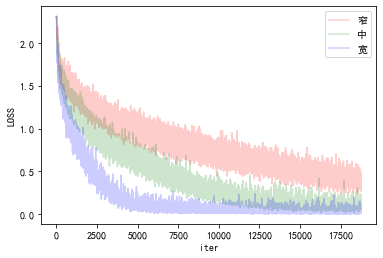

In [20]:
plt.xlabel("iter")
plt.ylabel("LOSS")
plt.plot(xloss,LOSS_S,label = "窄",c='r',alpha = 0.2)
plt.plot(xloss,LOSS_M,label = "中",c='g',alpha = 0.2)
plt.plot(xloss,LOSS_D,label = "宽",c='b',alpha = 0.2)
plt.legend()
plt.savefig("width_LOSS1.jpg")

### 所有epoch的LOSS曲线

In [21]:
#计算每个epoch的平均LOSS
ls,lm,ld = [],[],[]
step = 250 #每个epoch有250个LOSS
for i in range(EPOCH):
    ls.append(np.mean(LOSS_S[int(i*step):int((i+1)*step-1)]))
    lm.append(np.mean(LOSS_M[int(i*step):int((i+1)*step-1)]))
    ld.append(np.mean(LOSS_D[int(i*step):int((i+1)*step-1)]))

In [22]:
xloss2 = np.arange(0,len(ls))

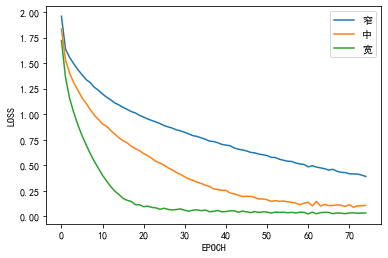

In [23]:
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.plot(xloss2,ls,label = "窄")
plt.plot(xloss2,lm,label = "中")
plt.plot(xloss2,ld,label = "宽")
plt.legend()
plt.savefig("width_LOSS2.jpg")

### 测试集精度

In [24]:
xac = np.arange(0,len(ACC_S))

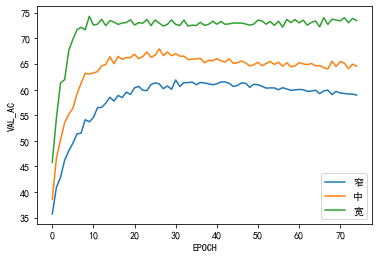

In [25]:
plt.xlabel("EPOCH")
plt.ylabel("VAL_AC")
plt.plot(xac,ACC_S,label = "窄")
plt.plot(xac,ACC_M,label = "中")
plt.plot(xac,ACC_D,label = "宽")
plt.legend()
plt.savefig("asd.jpg")
plt.savefig("width_ACC.jpg")